In [1]:
import matplotlib.pyplot as plt
import importlib.util
import pandas as pd
import numpy as np
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib
import os
from crashpy.utilities import crashMemMap
from matplotlib.colors import LogNorm
from matplotlib.colors import Normalize

import warnings
warnings.filterwarnings('ignore')

from IPython.core.interactiveshell import InteractiveShell

# pretty print all cell's output and not just the last one
InteractiveShell.ast_node_interactivity = "all"

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:75% !important; }</style>"))

In [7]:
def place_fesc(fesc_arr, threshold=1e-3):
    frac_small = (fesc_arr < threshold).sum()/len(fesc_arr)
    
    fesc_new = np.zeros_like(fesc_arr)
    for i, fesc in enumerate(fesc_arr):
        if fesc < threshold:
            fesc_new[i] = 1.5*threshold+np.random.uniform(-0.5*threshold, 0.5*threshold) 
        else:
            fesc_new[i] = fesc
    return frac_small, fesc_new

In [137]:
def get_scatter(df, props, x_prop='StarMass', bin_width=0.1, mode='median', threshhold=1e-3, relative=False):
    
    f_esc = df.loc[:,'f_esc']
    x_values = df.loc[:,x_prop]
    bins = int((np.log10(x_values.max())-np.log10(x_values.min()))/bin_width)
    edges = np.logspace(np.log10(x_values.min()),np.log10(x_values.max()), bins)
    
    prop_norm = {}
    for prop in props:
        tot=0
        prop_norm[prop]=[]
        for i in range(len(edges)-1):
            column = df[(edges[i]*(1-1e-10)<df[x_prop]) & (df[x_prop]<edges[i+1])][prop]
            if mode == 'median':
                if relative:
                    new_data=column/column.median()
                else:
                    new_data=column-column.median()
            elif mode == 'mean':
                if relative:
                    new_data=column/column.mean()
                else:
                    new_data=column-column.mean()
            
            prop_norm[prop].extend(new_data)
    return x_values, f_esc, prop_norm

In [133]:
def plot_scatter_color(df, props, x_prop='StarMass', bin_width=0.1, mode='median', threshold=1e-3, relative=False, log=False, save = False):
        
    if x_prop == 'HaloMass':
        mult = 1e10
        x_label = 'Halo Mass [$\log(M_{\mathrm{sun}})$]'
    elif x_prop == 'StarMass':
        mult = 1e6
        x_label = 'Stellar Mass [$\log(M_{\mathrm{sun}})$]'
    else:
        raise ValueError("Only defined for the properties 'HaloMass' and 'StarMass'")
    
    x_values, f_esc, prop_norm = get_scatter(df, props=props, x_prop=x_prop, bin_width=bin_width, mode=mode, threshhold=threshold, relative=relative)
    
    y_axis = 'f_esc' 
    y_label = '$f_\mathrm{esc}$'

    frac_small, f_esc_plot = place_fesc(f_esc, threshold)
    
    f, axarr = plt.subplots(int(np.ceil(len(props)/2)), 2)
    
    for i,prop in enumerate(props):
        if log:
            color_data = np.log10(prop_norm[prop])
            bar_label = f'$\log(\Delta ${prop})'
        else:
            color_data = prop_norm[prop]
            bar_label = f'$\Delta ${prop}'
            
        subfig = axarr[i//2, i%2].scatter(np.log10(x_values*mult), f_esc_plot, c=color_data)
        axarr[i//2, i%2].set_yscale('log')
        axarr[i//2, i%2].set_ylim(threshold,1.)
        axarr[i//2, i%2].set_xlabel(x_label, size=35)
        axarr[i//2, i%2].set_ylabel(y_label, size=35)
        axarr[i//2, i%2].tick_params(length=16, width=4)
        axarr[i//2, i%2].tick_params(length=8, width=3, which='minor')
        #axarr[i//2, i%2].legend(fontsize=30)
        
        divider = make_axes_locatable(axarr[i//2, i%2])
        cax = divider.append_axes("right", size="5%", pad=0.1)
        cbar = f.colorbar(subfig, cax=cax)
        cbar.set_label(bar_label, size=30)
        cbar.ax.tick_params(labelsize=15)

    xticklabels = axarr[i//2, i%2].get_xticklabels()
    plt.setp(xticklabels, visible=True)
    plt.rcParams["figure.figsize"] = (20,25)
    plt.rc('axes', linewidth=2)
    plt.rc('xtick', labelsize=30) 
    plt.rc('ytick', labelsize=30) 
    
    if len(props)%2==1:
        f.delaxes(axarr[int(np.floor(len(props)/2)), 1])
    plt.rcParams["figure.figsize"] = (20,10*np.ceil(len(props)/2.))
    plt.tight_layout(rect=(0,0,1,0.7))
    
    if save:
        plt.savefig(f'/u/ivkos/analysis/plots/{x_prop}_scatter_{props[0]}.pdf')
    plt.show();
    return

In [11]:
def lum_str_to_float(string):
    string = string.replace('d', 'e')
    return float(string)

In [12]:
def source_dist_lum(ID, redshift, conf, side_length, r_v):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    # 0.5 is needed to take into account that the sources are at the center of the grid voxel, move origin to halo center
    coord = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[0,1,2])+0.5-side_length/2
    lum = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[3])
    dist = np.sqrt(np.sum(coord**2, axis=1))*2*r_v/side_length

    dist_lum_df = pd.DataFrame({'dist':dist,'lum':lum[3]})
    dist_lum_df.sort_values('dist', inplace=True)

    return dist_lum_df

In [13]:
def source_dist_lum(ID, redshift, conf, side_length, r_v):
    snap = redshift_to_snap(redshift)
    path_sources = f'/ptmp/mpa/mglatzle/TNG_f_esc/{conf}/run/L35n2160TNG/{snap}/g{ID}/Input/sources_ic00.in'
    
    # 0.5 is needed to take into account that the sources are at the center of the grid voxel, move origin to halo center
    coord = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[0,1,2])+0.5-side_length/2
    lum = pd.read_csv(path_sources, delim_whitespace=True, header=None, usecols=[3])
    dist = np.sqrt(np.sum(coord**2, axis=1))*2*r_v/side_length

    dist_lum_df = pd.DataFrame({'dist':dist,'lum':lum[3]})
    dist_lum_df.sort_values('dist', inplace=True)

    return dist_lum_df

In [14]:
def mass_dens_r(dist_lum_df, frac, r_v):
    lum = np.vectorize(lum_str_to_float)(dist_lum_df['lum'])
    sorted_dist = np.array(dist_lum_df['dist'])

    frac_lum = frac*lum.sum()
    
    radius_idx = 0
    tot_lum = 0.
    while tot_lum <= frac_lum:
        prev_lum = tot_lum
        tot_lum += lum[radius_idx]
        radius_idx += 1
        
    contribution_idx1 = (tot_lum-frac_lum)/(tot_lum-prev_lum)
    contribution_idx2 = 1-contribution_idx1
    
    r_frac = contribution_idx1*sorted_dist[radius_idx-2]+contribution_idx2*sorted_dist[radius_idx-1]
    return r_frac

In [15]:
def update_mass_rad(df, frac, conf):
    radii = []
    for index, row in df.iterrows():
        dist_lum_df = source_dist_lum(ID=row.ID, redshift=row.z, conf=conf, side_length=row.GridSize, r_v=row.HaloRadii)
        r_frac = mass_dens_r(dist_lum_df=dist_lum_df, frac=frac, r_v=row.HaloRadii)
        radii.append(r_frac)
    new_column_name = f'r_mass_{int(frac*100)}'
    df[new_column_name] = radii

In [16]:
def redshift_to_snap(redshift):
    snapnames = {6:'sn013', 8:'sn008', 10:'sn004'}
    return snapnames[redshift]

In [118]:
def update_df(df):
    df['Q0/HaloMass']=df['Q0']/df['HaloMass']
    df['avg_dens']=df['HaloMass']*3/(df['HaloRadii']**3*4)
    df['StarMass']= df['HaloMass']*df['FractionStars']*1e4
    df['SFR/StarMass']= df['SFR']*df['StarMass']/1e4
    return

In [122]:
def add_relative_mass_r(df, mass_r_frac):
    df[f'R_M,{int(frac*100)}']=df['HaloRadii']/df[f'r_mass_{int(frac*100)}']
    return

In [152]:
df = pd.read_hdf('df_f_esc_freq.h5', 'no_dust')
frac = 0.5
update_mass_rad(df, frac,'fid2')
update_df(df)
add_relative_mass_r(df, frac)

In [153]:
df.columns

Index(['ID', 'z', 'HaloMass', 'Metallicity', 'FractionStars', 'FractionGas',
       'FractionDust', 'Q0', 'aStar', 'HaloRadii', 'f_esc', 'Temperature',
       'xHII', 'xHeII', 'xHeIII', 'GridSize', 'BHMass', 'BHGrowth', 'SFR',
       'density', 'clumping', 'per_freq', 'per_source', 'emitted_photons',
       'escaped_photons', 'frequencies', 'n_iterations', 'r_mass_50',
       'Q0/HaloMass', 'avg_dens', 'StarMass', 'SFR/StarMass', 'R_M,50'],
      dtype='object')

In [159]:
a = [1,2,3,4]
b = [1,2]
a+b

[1, 2, 3, 4, 1, 2]

In [160]:
props1 = ['HaloMass', 'FractionGas', 'FractionDust', 'Metallicity']#, 'density']
props2 = ['xHII', 'xHeII', 'xHeIII', 'Temperature']
props3 = ['R_M,50', 'avg_dens', 'clumping', 'SFR/StarMass']
props4 =  props1+props2+props3

In [175]:
df.clumping.describe()

count    3123.000000
mean       22.927724
std        17.781365
min         3.395960
25%        11.631127
50%        17.144104
75%        27.402759
max       146.117335
Name: clumping, dtype: float64

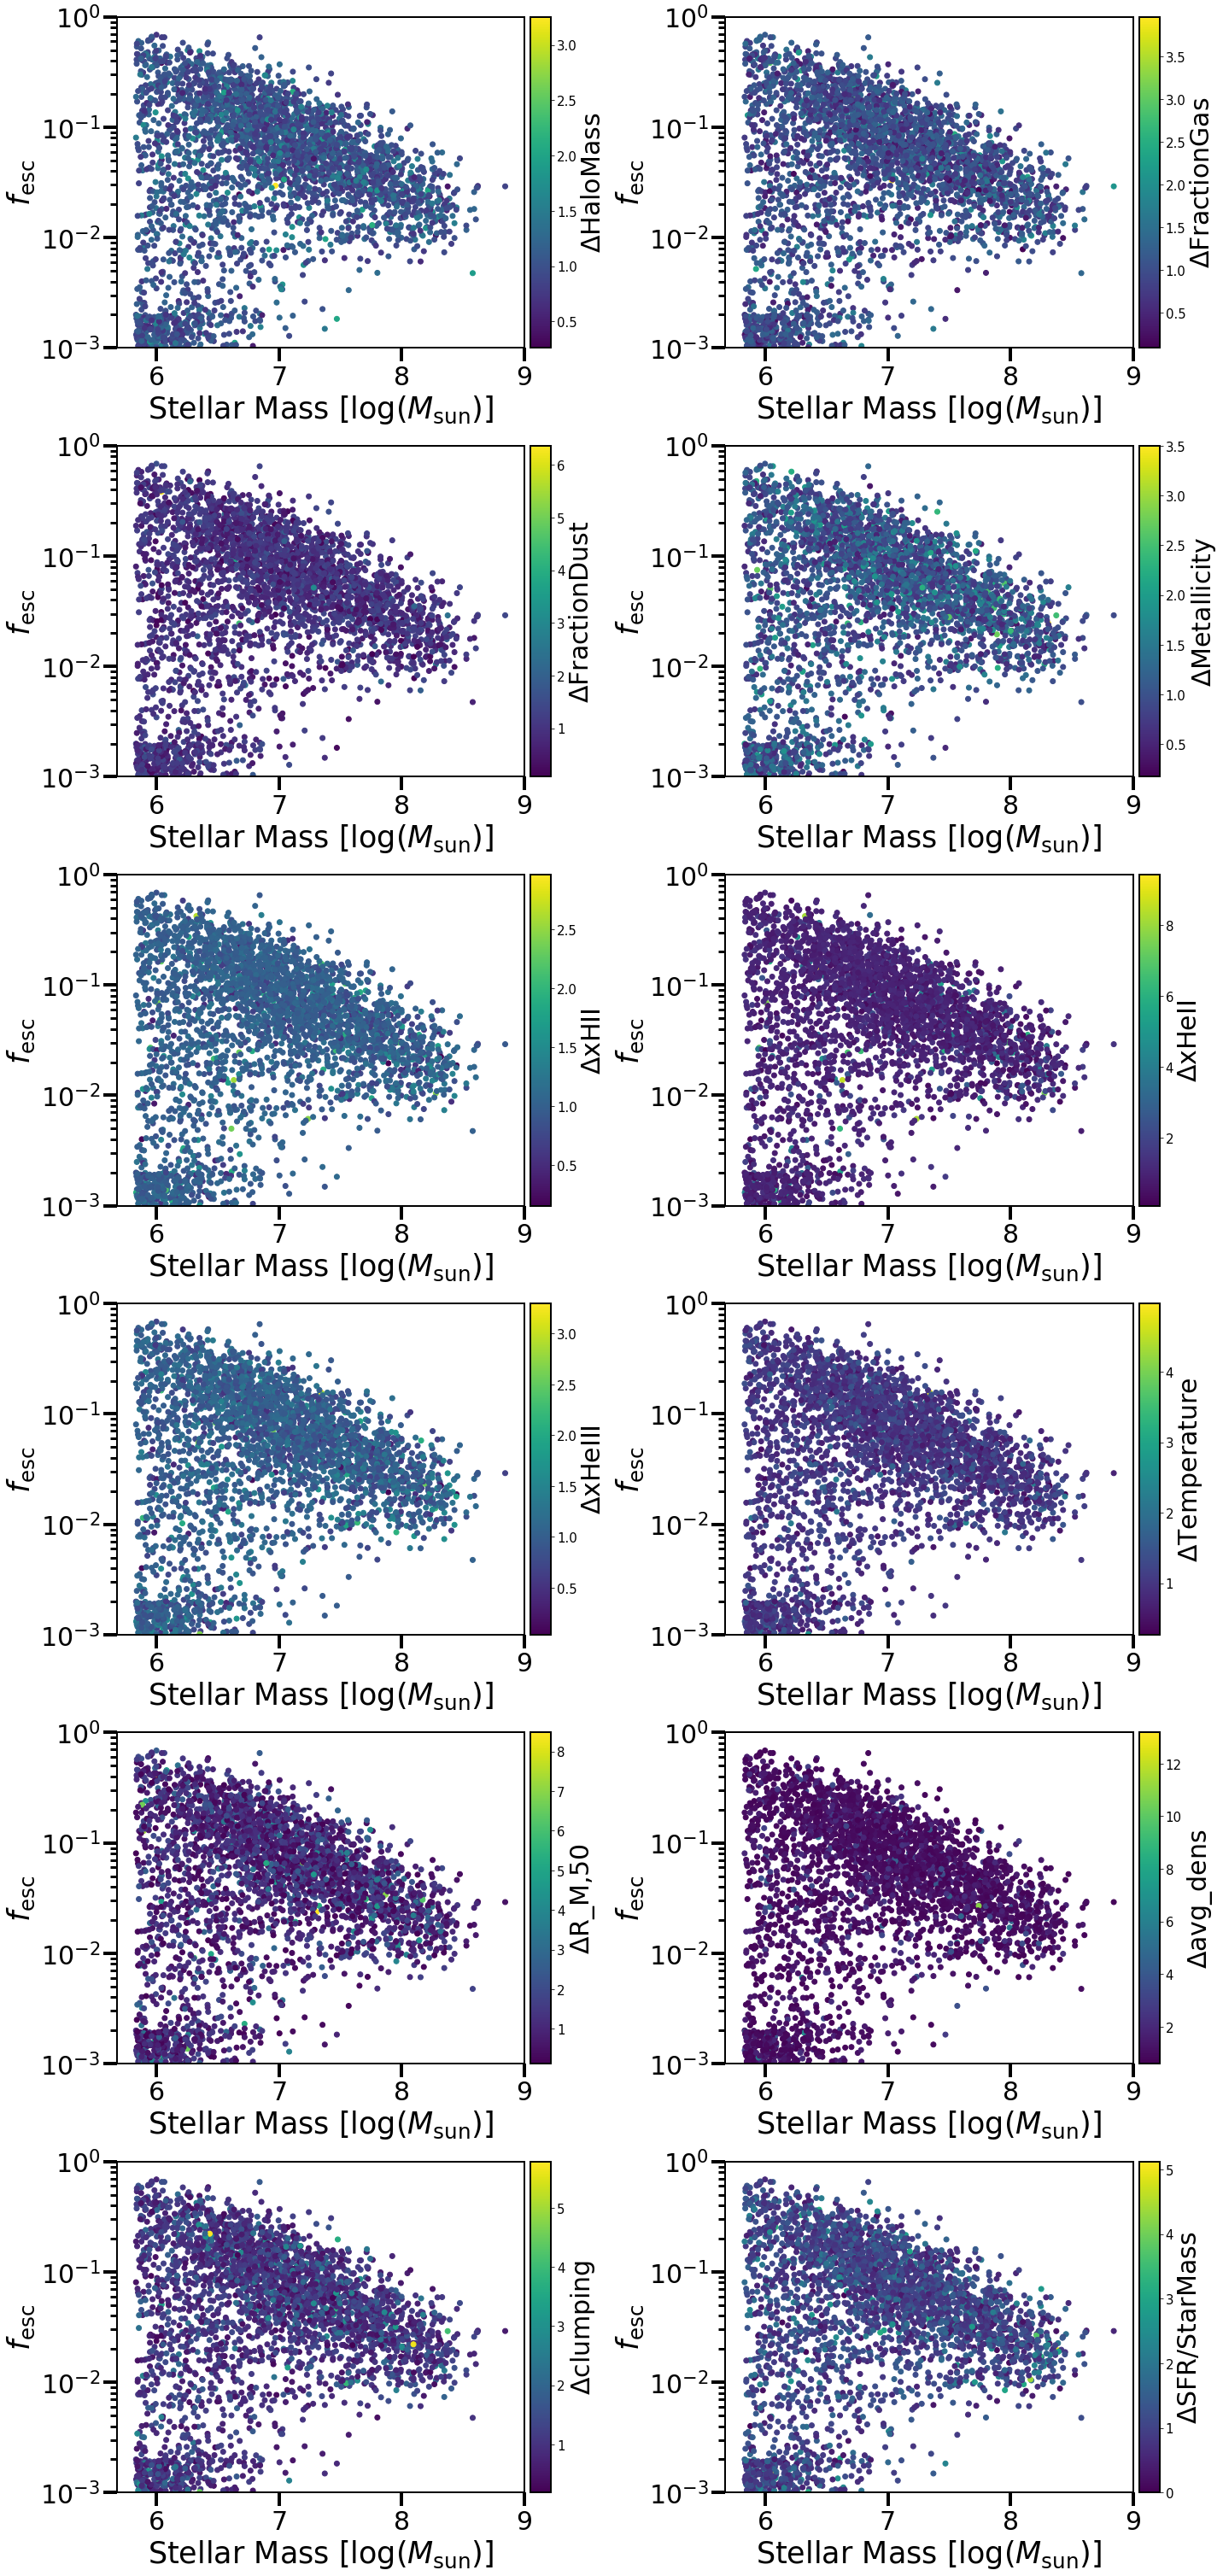

In [174]:
plot_scatter_color(df, props=props4, x_prop='StarMass', bin_width=0.1, mode='median', threshold=1e-3, relative=True, log=False, save=False)

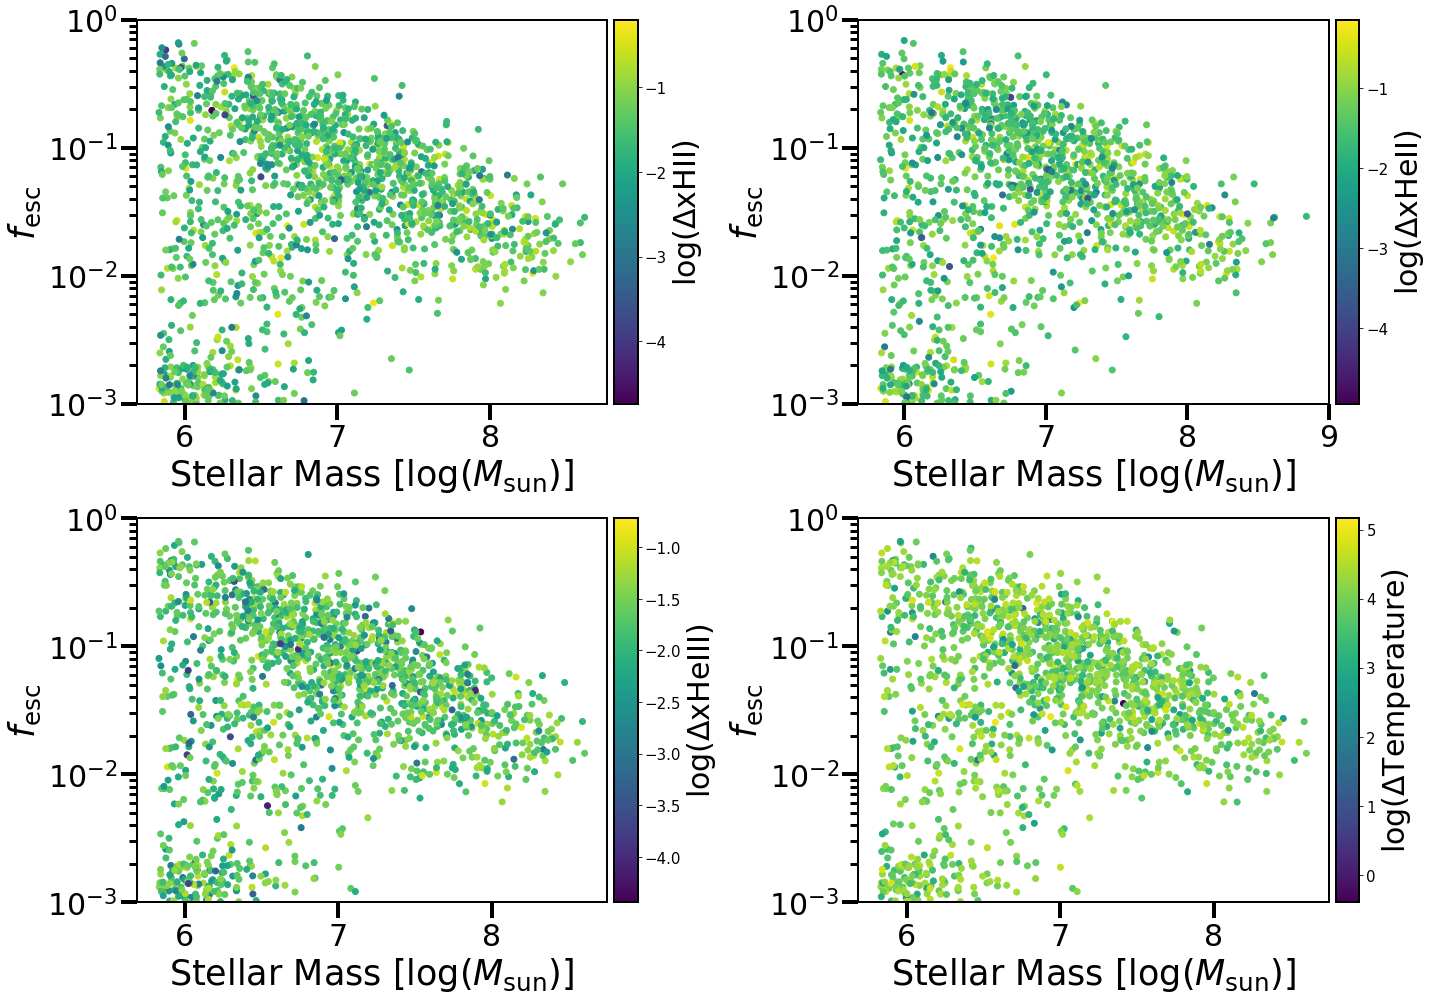

In [157]:
plot_scatter_color(df, props=props2, x_prop='StarMass', bin_width=0.1, mode='mean', threshold=1e-3, relative=False, log=True, save=False)

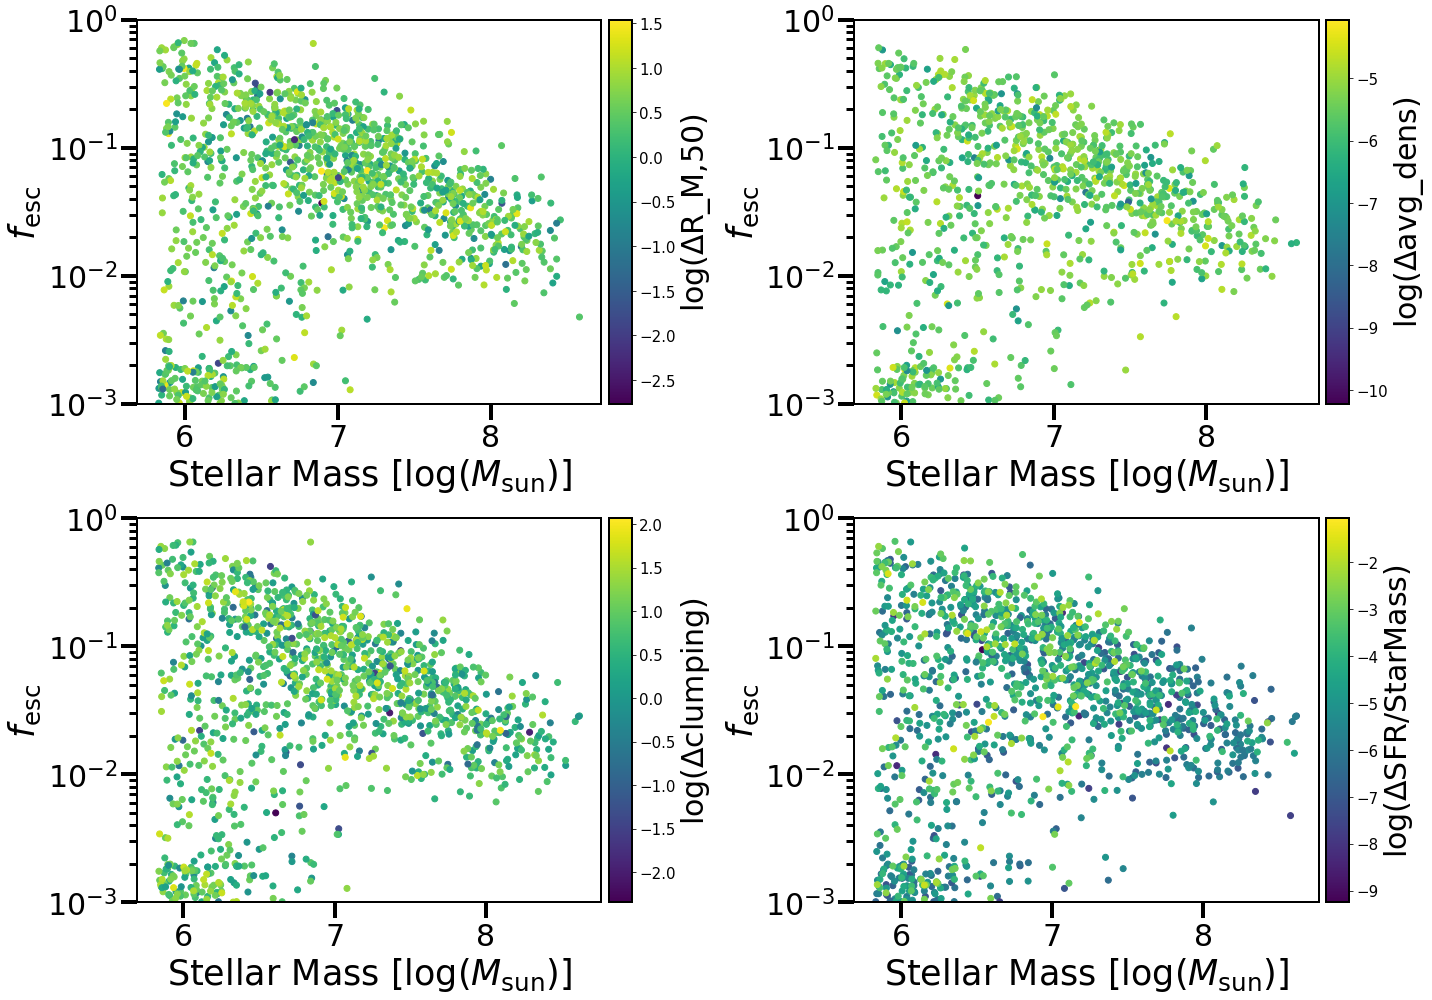

In [158]:
plot_scatter_color(df, props=props3, x_prop='StarMass', bin_width=0.1, mode='mean', threshold=1e-3, relative=False, log=True, save=False)